In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row

In [6]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [7]:
cuts_cat = Table.read('./Catalog/COSMOS/lsbg_COSMOS_after_cuts_JG.fits')

## Make merian N708 cutouts

In [8]:
# Load Merian Image
#c4d_210306_011257_osj_N708_deep.fits.fz
#c4d_210307_021334_osj_N708_wide
# merian_hdu = fits.open('/tigress/MERIAN/merian/cosmos_stack/c4d_210307_021334_osj_N708_wide.fits.fz')
merian_hdu = fits.open('/tigress/MERIAN/merian/cosmos_stack/c4d_210306_011257_osj_N708_deep.fits.fz')
merian_hdu[1].header['RADESYS']='FK5' 
w_img = wcs.WCS(merian_hdu[1].header)
img = merian_hdu[1].data

In [9]:
footprint = w_img.calc_footprint()

In [13]:
print('ZP=', merian_hdu[0].header['MAGZERO'])
skysub = merian_hdu[0].header['SKYSUB']
print('SKYSUB=', skysub)

img -= skysub

ZP= 30.658
SKYSUB= 368.0004


In [15]:
img *= 10**((27.0 - merian_hdu[0].header['MAGZERO']) / 2.5) # scale to ZP = 27.0

In [9]:
from kuaizi.display import draw_circles

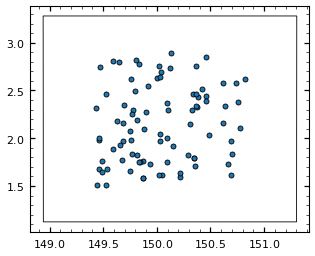

In [110]:
plt.scatter(cuts_cat['ra'], cuts_cat['dec'])
plt.gca().add_patch(Polygon(footprint, edgecolor='k', fill=False))

In [133]:
## For visual inspection
# cuts_cat = cuts_cat[cuts_cat['SB_eff_avg'][:, 0] > 24.3]
cuts_cat[['viz-id', 
          'ra', 
          'dec']].write('/tigress/jiaxuanl/public_html/galary/catalogs/cosmos_lsbg_candidates.txt', 
                        format='ascii', overwrite=True)

cuts_cat[cuts_cat['SB_eff_avg'][:, 0] > 24.3][['viz-id', 
          'ra', 
          'dec']].write('/tigress/jiaxuanl/public_html/galary/catalogs/cosmos_udg_candidates.txt', 
                        format='ascii', overwrite=True)

In [16]:
cosmos_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/LSBG_Merian_COSMOS.txt', format='ascii')

In [19]:
temp = cuts_cat[np.in1d(cuts_cat['viz-id'], cosmos_cat['viz-id'])]

In [24]:
cosmos_cat.sort('viz-id')

In [25]:
temp.sort('viz-id')

In [31]:
temp['rhalf_circularized'] * 0.168

1.7807058220117757
2.3925638987600317
2.13028549787222
1.8756347301748344
2.3540495829349743
1.9138855411392492
1.8943925663940884
1.994271590015379
2.346550900753258


In [29]:
cosmos_cat

viz-id,ra,dec,z_cosmos,mass_cosmos,spec_z
int64,float64,float64,float64,float64,str5
4769,150.2118473,1.5943874,0.07999999821186066,8.39539,false
10852,150.694951,1.9673856,0.07490000128746033,8.74963,false
26933,150.026504,2.046018,0.0919,8.2,true
52338,149.9191068,2.5421561,0.0706000030040741,8.3,false
57824,150.0332065,1.9700456,0.08377061,9.15538,true
67524,149.8122526,1.8195853,0.08049999922513962,8.66131,false
69467,149.5304835,2.4596792,0.09099999815225601,8.76018,false
75388,150.0953542,1.7459822,0.10100000351667404,8.30001,true
83743,150.0262369,2.6357667,0.055399999022483826,9.05,true


In [37]:
from astropy.cosmology import Planck15
temp['rhalf_circularized_phys'] = Planck15.angular_diameter_distance(
    cosmos_cat['z_cosmos']).value * (temp['rhalf_circularized'] * 0.168) / 206265 * 1000

In [40]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

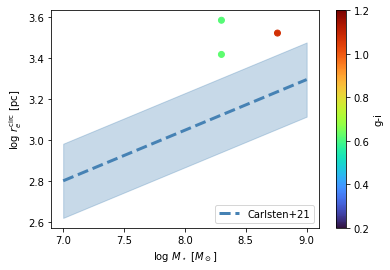

In [67]:
sct = plt.scatter(cosmos_cat[flag]['mass_cosmos'], 
                  np.log10(temp[flag]['rhalf_circularized_phys']) + 3, 
                  c=(temp['mag'][:, 0] - temp['mag'][:, 2])[flag], 
                  cmap='turbo', vmin=0.2, vmax=1.2)

plt.colorbar(label='g-i')

x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(loc='lower right')

In [53]:
len(temp)

9

In [61]:
print(cosmos_cat)

viz-id      ra        dec          z_cosmos       mass_cosmos spec_z
------ ----------- --------- -------------------- ----------- ------
  4769 150.2118473 1.5943874  0.07999999821186066     8.39539  false
 10852  150.694951 1.9673856  0.07490000128746033     8.74963  false
 26933  150.026504  2.046018               0.0919         8.2   true
 52338 149.9191068 2.5421561   0.0706000030040741         8.3  false
 57824 150.0332065 1.9700456           0.08377061     9.15538   true
 67524 149.8122526 1.8195853  0.08049999922513962     8.66131  false
 69467 149.5304835 2.4596792  0.09099999815225601     8.76018  false
 75388 150.0953542 1.7459822  0.10100000351667404     8.30001   true
 83743 150.0262369 2.6357667 0.055399999022483826        9.05   true


In [62]:
flag = np.in1d(cosmos_cat['viz-id'], [52338, 69467, 75388])

In [65]:
temp[flag]['SB_eff_avg'][:, 0], temp[flag]['SB_0'][:, 0]

(<Column name='SB_eff_avg' dtype='float64' length=3>
  24.26576805114746
  24.65890121459961
 24.979663848876953,
 <Column name='SB_0' dtype='float64' length=3>
   23.5949764251709
 23.973482131958008
 23.954666137695312)

In [57]:
temp[temp['SB_eff_avg'][:, 0] > 24.]['viz-id']

10852
52338
69467
75388


In [13]:
# Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/cosmos_lsbg_candidates.txt', format='ascii')

In [147]:
vis_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/udg_visual_inspec.txt', format='ascii')
vis_cat = vis_cat[vis_cat['marked'] == 'true']

In [148]:
print(vis_cat)

viz-id      ra        dec    marked
------ ----------- --------- ------
  1203 150.3456186 1.7934761   true
  5278 150.6949605 1.6139068   true
 40915 149.4852915 1.7644933   true
 41653 150.0991429 2.3682481   true
 43216 149.9027607 2.2783959   true
 51341 149.5314403 1.6786744   true
 51681 150.3666491 2.3403151   true
 56140 149.8826523 2.0968221   true
 68828 149.4413136  1.506012   true
 75388 150.0953542 1.7459822   true
 88796 149.7679251 2.2547939   true


In [111]:
# Make merian N708 cutouts
from kuaizi.utils import img_cutout
filt = 'N708'
for obj in cuts_cat:
    obj_id = obj['viz-id']
    
    x, y = w_img.wcs_world2pix(obj['ra'], obj['dec'], 0)
    
    if not os.path.isdir(f'./Cutout/cosmos_udg/'):
        os.makedirs(f'./Cutout/cosmos_udg/')

    img_cut, [cen_pos, dx, dy], img_cut_header = img_cutout(
        img,
        w_img, obj['ra'], obj['dec'], # subtract a global bkg
        size=[obj['radius'] * 2 * 60, obj['radius'] * 2 * 60],
        pixel_scale=0.27,
        save=False,)
    
    img_cut_header['RADESYS'] = 'FK5' 
    img_cut_header['CDELT1'] = img_cut_header['CD1_1']
    img_cut_header['CDELT2'] = img_cut_header['CD2_2']
    
    hdu1 = fits.HDUList([
        fits.PrimaryHDU(header=merian_hdu[0].header),  # header
        fits.ImageHDU(data=img_cut.data, header=img_cut_header,
                      name='IMAGE'),  # image
    ])
        

    fits_file = f'cosmos_{obj_id}_{filt}' + '.fits'
    fits_file = os.path.join(f'./Cutout/cosmos_udg/', fits_file)

    hdu1.writeto(fits_file, overwrite=True)

### Make RGB plot for `griz+N708`

In [15]:
from kuaizi.mock import Data
import kuaizi.multicolorfits as mcf
from kuaizi.display import display_merian_cutout_rgb
import kuaizi
kuaizi.set_matplotlib(style='nature', usetex=False)

kapteyn package required for some options in task reproject2D()


In [113]:
CUTOUT_DIR = '/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/COSMOS/'
MERIAN_DIR = '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/cosmos_udg/'

In [114]:
ind = 8648
obj = cuts_cat[cuts_cat['viz-id'] == ind][0]
cutout_halfsize = 22.5 # 0.75 arcmin
#int(obj['cutout_size'] * 60) # arcsec

ref_filt = 'i'
dataset = {}

In [115]:
# Reference bandpass
filt = ref_filt

filedir = f'{MERIAN_DIR}/cosmos_{ind}_{filt}.fits' if filt == 'N708' else f'{CUTOUT_DIR}/cosmos_{ind}_{filt}.fits'
gal_img, gal_hdr = fits.getdata(filedir, header=True)
_, ref_hdr_crop = mcf.cropfits2D_coords(gal_img, 
                                        mcf.makesimpleheader(gal_hdr, radesys='FK5'), 
                                        [obj['ra'], obj['dec']], 
                                        cutout_halfsize)
for filt in list('grizy') + ['N708']:
    filedir = f'{MERIAN_DIR}/cosmos_{ind}_{filt}.fits' if filt == 'N708' else f'{CUTOUT_DIR}/cosmos_{ind}_{filt}.fits'
    gal_img, gal_hdr = fits.getdata(filedir, header=True)
    gal_crop_img = mcf.reproject2D(gal_img, mcf.makesimpleheader(gal_hdr), ref_hdr_crop);
    dataset[filt] = Data(gal_crop_img, wcs=wcs.WCS(ref_hdr_crop))

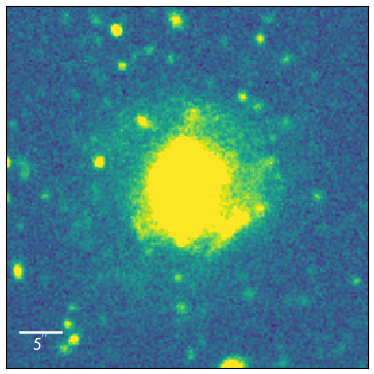

In [116]:
display_single(dataset['N708'].images);

In [ ]:
plt.savefig(FIGURE_DIR + f'cosmos_{ind}_cutout.png', dpi=70, 
                    bbox_inches='tight', pad_inches=0)

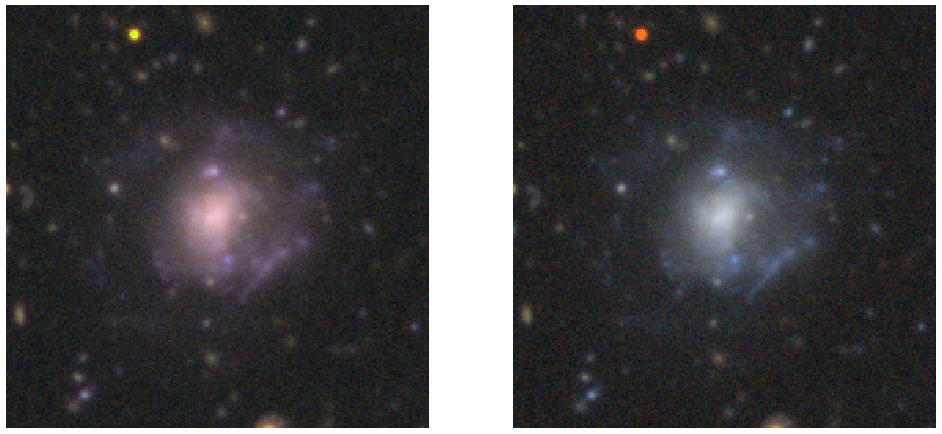

In [117]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))

_img = np.asarray([dataset[filt].images for filt in list('griz') + ['N708']])
display_merian_cutout_rgb(_img, filters=list('griz') + ['N708'], ax=ax1);

_img = np.asarray([dataset[filt].images for filt in list('griz')])
display_merian_cutout_rgb(_img, filters=list('griz'), ax=ax2);

In [118]:
category = "UDG"

In [119]:
FIGURE_DIR = '/tigress/jiaxuanl/Data/HSC/LSBG/Figure/cosmos-udg/Cutout_RGB/'

In [120]:
cat = cuts_cat

In [121]:
problem_ids = []
# Check file exsistence
for filt in list('griz'):
    for obj in cat:
        if not os.path.isfile(os.path.join(CUTOUT_DIR, f"cosmos_{obj['viz-id']}_{filt}.fits")):
            #print(f"NSA/nsa_{obj['viz-id']}_{filt}.fits not found!")
            problem_ids.append(obj['viz-id'])
            
for filt in ['N708']:
    for obj in cat:
        if not os.path.isfile(os.path.join(MERIAN_DIR, f"cosmos_{obj['viz-id']}_{filt}.fits")):
            #print(f"NSA/nsa_{obj['viz-id']}_{filt}.fits not found!")
            problem_ids.append(obj['viz-id'])
            
if not os.path.isdir(FIGURE_DIR):
    os.makedirs(FIGURE_DIR)
    
print('# of no cutouts:', np.unique(problem_ids).shape)

# of no cutouts: (0,)


In [123]:
def reproject_merian(obj, ref_filt):
    ind = obj['viz-id']
    # Reference bandpass
    filt = ref_filt
    filedir = f'{MERIAN_DIR}/cosmos_{ind}_{filt}.fits' if filt == 'N708' else f'{CUTOUT_DIR}/cosmos_{ind}_{filt}.fits'
    gal_img, gal_hdr = fits.getdata(filedir, header=True)
    _, ref_hdr_crop = mcf.cropfits2D_coords(gal_img, 
                                            mcf.makesimpleheader(gal_hdr, radesys='FK5'), 
                                            [obj['ra'], obj['dec']], 
                                            cutout_halfsize)
    for filt in list('grizy') + ['N708']:
        filedir = f'{MERIAN_DIR}/cosmos_{ind}_{filt}.fits' if filt == 'N708' else f'{CUTOUT_DIR}/cosmos_{ind}_{filt}.fits'
        gal_img, gal_hdr = fits.getdata(filedir, header=True)
        gal_crop_img = mcf.reproject2D(gal_img, mcf.makesimpleheader(gal_hdr), ref_hdr_crop);
        dataset[filt] = Data(gal_crop_img, wcs=wcs.WCS(ref_hdr_crop))
        
    return dataset

In [126]:
# Save each RGB figure
cutout_halfsize = 22.5 # arcsec
ref_filt = 'i'
    
for i, obj in enumerate(cat[:1]):
    ind = obj['viz-id']
    
    try:
        dataset = reproject_merian(obj, 'i')
        _img = np.asarray([dataset[filt].images for filt in list('griz') + ['N708']])
        fig, ax = plt.subplots(figsize=(5, 5))
        display_merian_cutout_rgb(_img, filters=list('griz') + ['N708'], ax=ax);
        plt.savefig(FIGURE_DIR + f'cosmos_{ind}_cutout.png', dpi=70, 
                    bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(ind, e)
        
    if i % 10 == 0:
        print(f'Progress: {i} / {len(cat)}')

Progress: 0 / 86
